In [6]:
##STEP 1 — Import Libraries

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

In [7]:
df = pd.read_excel('mockUsers.xlsx')

print(df.head(30))

                  Name                            Email      Password    Role  \
0       Oluwaseun Juma      oluwaseun.juma@mentor.match  Password123!  mentee   
1        Hadiya Torres       hadiya.torres@mentor.match  Password123!  mentee   
2   Emmanuel Hernandez  emmanuel.hernandez@mentor.match  Password123!  mentee   
3      Sergei Vasiliev     sergei.vasiliev@mentor.match  Password123!  mentee   
4            Amal Diaz           amal.diaz@mentor.match  Password123!  mentee   
5    Oluwaseun Abiodun   oluwaseun.abiodun@mentor.match  Password123!  mentee   
6        Leila Morozov       leila.morozov@mentor.match  Password123!  mentee   
7           James Juma          james.juma@mentor.match  Password123!  mentee   
8      Dmitri Anderson     dmitri.anderson@mentor.match  Password123!  mentee   
9           Nadia Nour          nadia.nour@mentor.match  Password123!  mentee   
10        Tolu Mustafa        tolu.mustafa@mentor.match  Password123!  mentee   
11         Lucas Karim      

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              1000 non-null   object 
 1   Email             1000 non-null   object 
 2   Password          1000 non-null   object 
 3   Role              1000 non-null   object 
 4   Career            1000 non-null   object 
 5   Experience Level  1000 non-null   object 
 6   Skills            1000 non-null   object 
 7   Languages         1000 non-null   object 
 8   Bio               1000 non-null   object 
 9   Availability      1000 non-null   object 
 10  Onboarded         1000 non-null   bool   
 11  Rating            156 non-null    float64
dtypes: bool(1), float64(1), object(10)
memory usage: 87.0+ KB


In [9]:
df.shape

(1000, 12)

In [10]:
##Normalize Roles

df['Role'] = df['Role'].astype(str).str.lower().str.strip()

In [11]:
## Clean List-Style Columns Convert comma-separated text → Python lists.

def clean_list_column(series):
    return (
        series.fillna('')
        .astype(str)
        .apply(lambda x: [s.strip().lower() for s in x.split(',') if s.strip()])
    )

df['skills_clean'] = clean_list_column(df['Skills'])
df['languages_clean'] = clean_list_column(df['Languages'])

In [12]:
##Build AI Feature Text : This becomes the AI profile representation.

cols = ['Skills', 'Languages', 'Career', 'Bio', 'Availability']

df['combined_text'] = (
    df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.lower()
)

print(df['combined_text'].head())

0    python, git, java, javascript english, spanish...
1    javascript, css, sql basics english, japanese ...
2    sketch, adobe xd, wireframing, design systems,...
3    javascript, html, css english, hindi computer ...
4    tableau, numpy, power bi, sql english, somali ...
Name: combined_text, dtype: object


In [13]:
##Clean Text Columns

df['career_clean'] = df['Career'].fillna('').astype(str).str.lower()
df['bio_clean'] = df['Bio'].fillna('').astype(str).str.lower()

In [14]:
experience_rank = {
    'beginner': 1,
    'junior': 2,
    'mid': 3,
    'senior': 4,
    'expert': 5
}

df['exp_rank'] = df['Experience Level'].map(experience_rank).fillna(0)


In [15]:
##Separate Mentors & Mentees

mentors = df[df['Role'] == 'mentor'].copy()
mentees = df[df['Role'] == 'mentee'].copy()

print("Mentors:", len(mentors))
print("Mentees:", len(mentees))

Mentors: 166
Mentees: 834


In [16]:
##Convert Text → Numeric Vectors (AI Core)

vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

In [17]:
##Compute Similarity Matrix

similarity_matrix = cosine_similarity(tfidf_matrix)

In [18]:
##Matching Logic (Top Mentors per Mentee) We rank mentors by similarity.

mentor_idx = mentors.index
mentee_idx = mentees.index

matches = []

for mentee_i in mentee_idx:

    scores = []

    for mentor_i in mentor_idx:
        score = similarity_matrix[mentee_i, mentor_i]
        scores.append((mentor_i, score))

    # Sort mentors by similarity
    top_matches = sorted(scores, key=lambda x: x[1], reverse=True)[:3]

    for rank, (mentor_i, score) in enumerate(top_matches, start=1):
        matches.append({
            'mentee': df.loc[mentee_i, 'Name'],
            'mentor': df.loc[mentor_i, 'Name'],
            'score': score,
            'rank': rank
        })

In [19]:
##Convert Matches → DataFrame

matches_df = pd.DataFrame(matches)

print(matches_df.head())

           mentee           mentor     score  rank
0  Oluwaseun Juma     Chiamaka Ali  0.175771     1
1  Oluwaseun Juma       Zara Karim  0.175753     2
2  Oluwaseun Juma    Carlos Moreno  0.170429     3
3   Hadiya Torres  Eduardo Mustafa  0.259326     1
4   Hadiya Torres  Fernando Mendez  0.226406     2


In [20]:
##

best_matches = matches_df[matches_df['rank'] == 1]

print(best_matches.sort_values('score', ascending=False).head(10))

                mentee           mentor     score  rank
1281         Mei Usman  Andrei Kowalski  0.605455     1
1440       Boris Usman      Zainab Musa  0.592419     1
939      Vladimir Osei   Chiamaka Udoka  0.582632     1
1374    Naledi Mokoena      Zainab Musa  0.579386     1
1329  Vladimir Sokolov   Chiamaka Udoka  0.577128     1
2430      Sergei Ahmed      Zainab Musa  0.574943     1
402     Dmitri Popescu   Chiamaka Udoka  0.573835     1
1083      Pavel Chinwe   Chiamaka Udoka  0.573126     1
1017    Rafael Nwankwo   Chiamaka Udoka  0.570384     1
1923      Aisha Volkov      Zainab Musa  0.564368     1


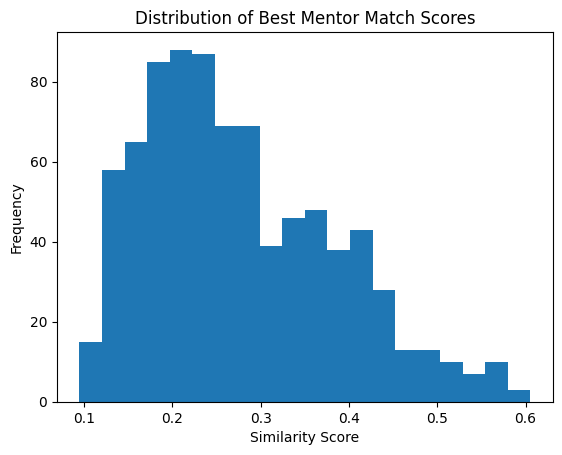

In [21]:
##Visualization 1: Similarity Score Distribution Shows overall matching quality.

plt.figure()
plt.hist(best_matches['score'], bins=20)
plt.title("Distribution of Best Mentor Match Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

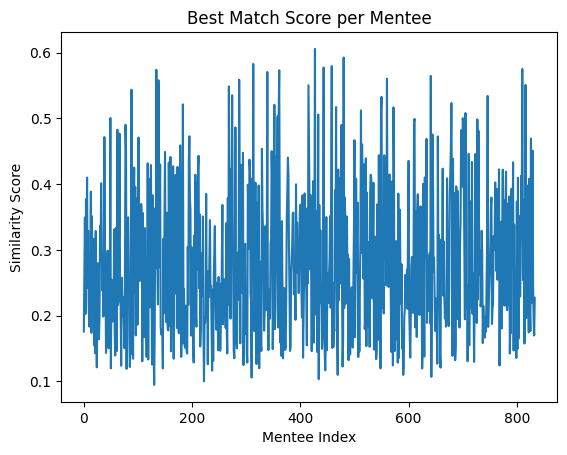

In [22]:
##Visualization 2: Top Match Scores per Mentee

plt.figure()
plt.plot(best_matches['score'].values)
plt.title("Best Match Score per Mentee")
plt.xlabel("Mentee Index")
plt.ylabel("Similarity Score")
plt.show()

In [23]:
##Experience Ranking Map: We convert experience → numeric intelligence.

experience_rank = {
    'beginner': 1,
    'junior': 2,
    'mid': 3,
    'senior': 4,
    'expert': 5
}

df['exp_rank'] = df['Experience Level'].map(experience_rank).fillna(0)

In [24]:
##Skill-Weighted Scoring


def skill_score(mentee_skills, mentor_skills):
    shared = set(mentee_skills) & set(mentor_skills)
    if not mentee_skills:
        return 0
    return len(shared) / len(set(mentee_skills))

In [25]:
##Language Compatibility

def language_score(mentee_lang, mentor_lang):
    shared = set(mentee_lang) & set(mentor_lang)
    return 1 if shared else 0

In [26]:
##Career Alignment

def career_score(mentee_career, mentor_career):
    return 1 if mentee_career == mentor_career else 0

In [27]:
## Availability Alignment

def availability_score(mentee_availability, mentor_availability):
    mentee_set =set(mentee_availability)
    if not mentee_availability: 
        return 0
    
    mentor_set = set(mentor_availability)
    shared = mentee_set & mentor_set
    return len(shared) / len(set(mentee_set))

In [28]:

def experience_score(mentee_exp, mentor_exp):
    diff = mentor_exp - mentee_exp

    if diff <= 0:
        return 0          # mentor not senior enough
    elif diff == 1:
        return 0.5        # slightly more experienced
    else:
        return 1          # ideal gap

In [29]:
##Bio Similarity (AI Layer)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')

bio_matrix = vectorizer.fit_transform(df['bio_clean'])
bio_similarity = cosine_similarity(bio_matrix)

In [30]:
##Composite Production Score: Weighted scoring (typical recommender strategy):

WEIGHTS = {
    'skills': 0.40,
    'career': 0.20,
    'language': 0.10,
    'experience': 0.15,
    'bio': 0.10,
    'availability': 0.05
}

In [ ]:
##Matching Engine

mentors = df[df['Role'] == 'mentor']
mentees = df[df['Role'] == 'mentee']

matches = []

for mentee_idx, mentee in mentees.iterrows():

    mentor_scores = []

    for mentor_idx, mentor in mentors.iterrows():

        s_score = skill_score(mentee['skills_clean'], mentor['skills_clean'])
        l_score = language_score(mentee['languages_clean'], mentor['languages_clean'])
        c_score = career_score(mentee['career_clean'], mentor['career_clean'])
        e_score = experience_score(mentee['exp_rank'], mentor['exp_rank'])
        b_score = bio_similarity[mentee_idx, mentor_idx]
     

        final_score = (
            WEIGHTS['skills'] * s_score +
            WEIGHTS['career'] * c_score +
            WEIGHTS['language'] * l_score +
            WEIGHTS['experience'] * e_score +
            WEIGHTS['bio'] * b_score
        )

        mentor_scores.append((mentor['Name'], final_score))

    top_mentors = sorted(mentor_scores, key=lambda x: x[1], reverse=True)[:3]

    for rank, (mentor_name, score) in enumerate(top_mentors, start=1):
        matches.append({
            'mentee': mentee['Name'],
            'mentor': mentor_name,
            'score': score,
            'rank': rank
        })

matches_df = pd.DataFrame(matches)
print(matches_df.head())

           mentee            mentor     score  rank
0  Oluwaseun Juma     Carlos Moreno  0.307603     1
1  Oluwaseun Juma   Andrei Kowalski  0.300000     2
2  Oluwaseun Juma      Amina Adeola  0.209432     3
3   Hadiya Torres  Rashida Anderson  0.236321     1
4   Hadiya Torres        Omar Lopez  0.236137     2


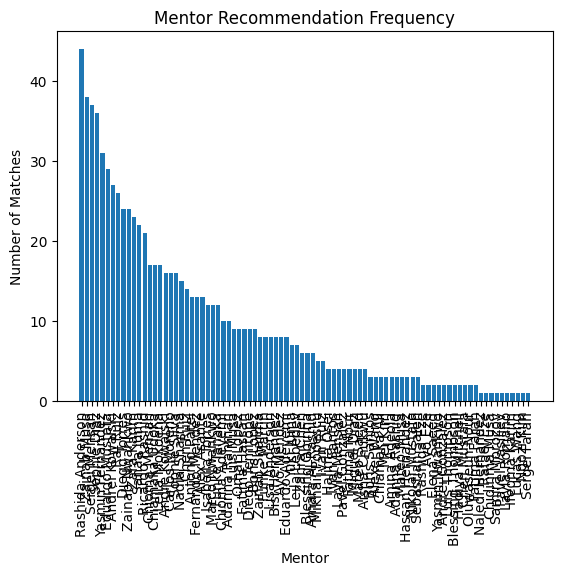

In [32]:
mentor_counts = best_matches['mentor'].value_counts()

plt.figure()
plt.bar(mentor_counts.index, mentor_counts.values)
plt.title("Mentor Recommendation Frequency")
plt.xlabel("Mentor")
plt.ylabel("Number of Matches")
plt.xticks(rotation=90)
plt.show()

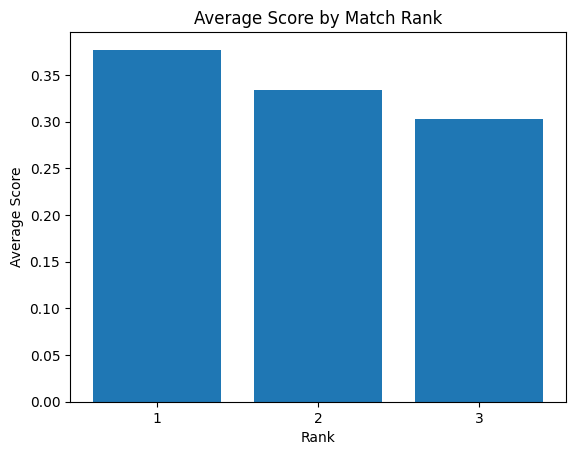

In [33]:
rank_avg = matches_df.groupby('rank')['score'].mean()

plt.figure()
plt.bar(rank_avg.index.astype(str), rank_avg.values)
plt.title("Average Score by Match Rank")
plt.xlabel("Rank")
plt.ylabel("Average Score")
plt.show()

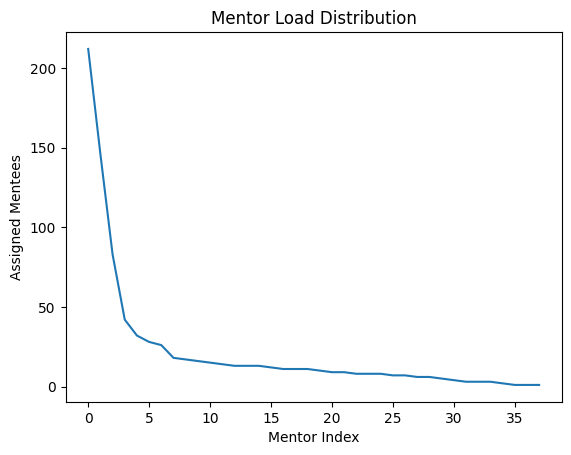

In [34]:
mentor_load = matches_df[matches_df['rank'] == 1]['mentor'].value_counts()

plt.figure()
plt.plot(mentor_load.values)
plt.title("Mentor Load Distribution")
plt.xlabel("Mentor Index")
plt.ylabel("Assigned Mentees")
plt.show()